In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt
import matplotlib 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [11]:
plt_width = plt_height = 16
matplotlib.rcParams['figure.figsize'] = [plt_width, plt_height]
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
#device = "cpu"

In [2]:
image_size = 784
hidden_size = 512
latent_dim = 128
batch_size = 256
epochs = 25

data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data_dir = 'VAE_Samples'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

batch_size = 1
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [3]:
class VarationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VarationalAutoEncoder, self).__init__()
        self.fc1 = nn.Linear(image_size, hidden_size)
        self.fc2_mean = nn.Linear(hidden_size, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, image_size)
        
    def encode(self, x):
        x = x.view(-1, image_size)
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        #std = logvar
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out
    
    def forward(self, x):
        # x: (batch_size, 1, 28,28) --> (batch_size, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
model = VarationalAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [4]:
def plot_images(images):
    if len(images) == 2:
        image = images[0]
        reconstructed = images[1]

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed, cmap='gray')
        plt.title('Reconstructed')
    
    else:
        for idx, image in enumerate(images):
            plt.subplot(1, len(images), idx+1)
            plt.imshow(image, cmap='gray')
            plt.title('Generated')
        
    plt.show()
    
    
def loss_function(reconstructed_image, original_image, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed_image, original_image.view(-1, 784), reduction = 'sum')
    #kld = torch.sum(0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, 1))
    kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return bce + kld


def train(model, epoch):
    model.train()
    train_loss = 0
    for idx, (images, label) in enumerate(train_loader):
        images = images.to(device)
        
        reconstructed, mu, logvar = model(images)
        loss = loss_function(reconstructed, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if (idx) % 1000 == 0:
            print("Train Epoch {} [Batch {}/{}]\tLoss: {:.3f}".format(epoch, idx, len(train_loader), loss.item()/len(images)))
            original = images[0].to("cpu")
            original = original.view(28,28).detach().numpy()
            re_img = reconstructed[0].to("cpu")
            re_img = re_img.view(28,28).detach().numpy()
            plot_images(images=[original, re_img])
    print("===> Epoch {}, Average loss: {:.3f}".format(epoch, train_loss/len(train_loader.dataset)))

    
def val(model):
    model.eval()
    model.to("cpu")
    test_loss = 0
    
    latent_array = None
    label_list = list()
    
    device = "cpu"
    
    for idx, (images, label) in enumerate(test_loader):
        
        images.detach()
        
        images = images.to(device)
        
        reconstructed, mu, logvar = model(images)
        reconstructed.detach()
        
        loss = loss_function(reconstructed, images, mu, logvar)
        
        label_list.append(float(label))
        
        mu, log_var = model.encode(images)
        mu, log_var = mu.cpu(), log_var.cpu()
        
        if latent_array is None:
            latent_array = mu
        else:
            latent_array = torch.cat((latent_array, mu), dim=0)
                    
        test_loss += loss.item()
        if (idx) % 3000 == 0:
            print("Test image idx {}, latent var value: {}, label: {}".format(idx, model.encode(images), label))
            original = images[0].to("cpu")
            original = original.view(28,28).detach().numpy()
            re_img = reconstructed[0].to("cpu")
            re_img = re_img.view(28,28).detach().numpy()
            plot_images(images=[original, re_img])
    print("===> Test, Average loss: {:.3f}".format(test_loss/len(test_loader.dataset)))
    
    return latent_array, label_list
    
    
def plot_latenet(latent, label_list, algo='tsne'):
    if not type(algo) == str:
        raise ValueError("-E- Algo Input must be String")
    latent_array = latent.detach().cpu()
    algo = algo.lower()
    if algo == 'tsne':
        result = TSNE(n_components=2, perplexity=100).fit_transform(latent_array)
    elif algo == 'pca':
        pca = PCA(n_components=2)
        pca.fit(latent_array)
        result = pca.transform(latent_array)
    plt.scatter(result[:, 0], result[:, 1], c=label_list)
    

Train Epoch 0 [Batch 0/235]	Loss: 549.996


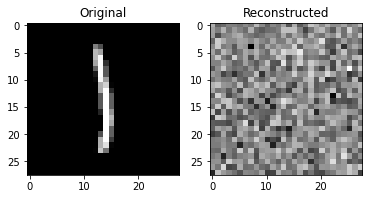

===> Epoch 0, Average loss: 190.411
Train Epoch 1 [Batch 0/235]	Loss: 151.269


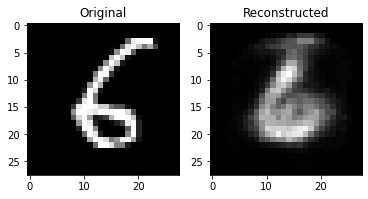

===> Epoch 1, Average loss: 141.062
Train Epoch 2 [Batch 0/235]	Loss: 133.702


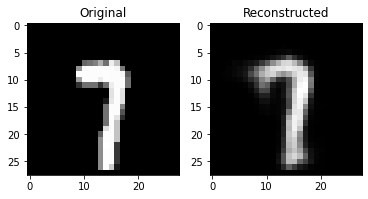

===> Epoch 2, Average loss: 128.384
Train Epoch 3 [Batch 0/235]	Loss: 123.676


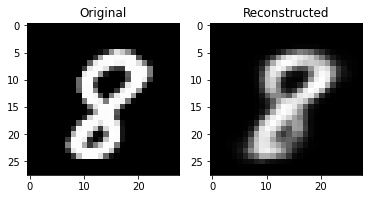

===> Epoch 3, Average loss: 120.796
Train Epoch 4 [Batch 0/235]	Loss: 118.462


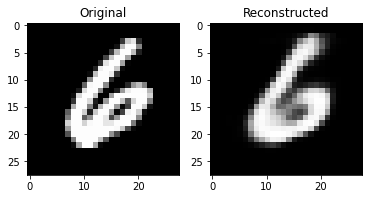

===> Epoch 4, Average loss: 115.914
Train Epoch 5 [Batch 0/235]	Loss: 113.899


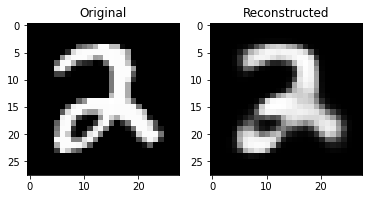

===> Epoch 5, Average loss: 112.861
Train Epoch 6 [Batch 0/235]	Loss: 114.607


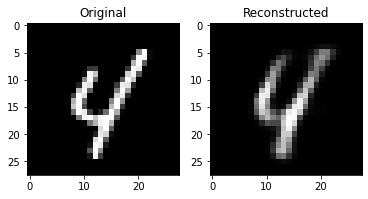

===> Epoch 6, Average loss: 110.783
Train Epoch 7 [Batch 0/235]	Loss: 111.077


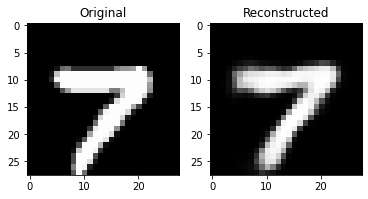

===> Epoch 7, Average loss: 109.367
Train Epoch 8 [Batch 0/235]	Loss: 106.791


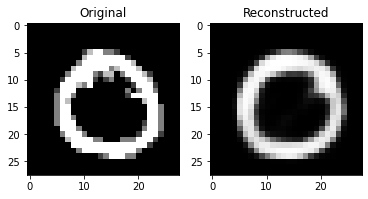

===> Epoch 8, Average loss: 108.365
Train Epoch 9 [Batch 0/235]	Loss: 107.573


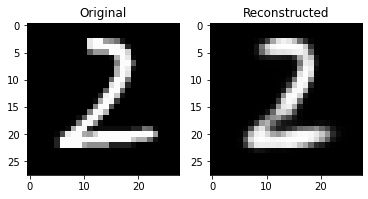

===> Epoch 9, Average loss: 107.558
Train Epoch 10 [Batch 0/235]	Loss: 106.946


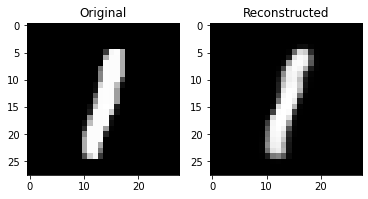

===> Epoch 10, Average loss: 106.941
Train Epoch 11 [Batch 0/235]	Loss: 106.463


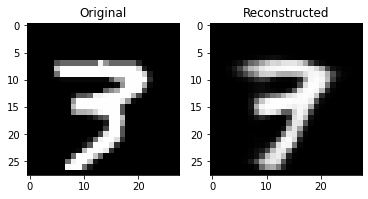

===> Epoch 11, Average loss: 106.521
Train Epoch 12 [Batch 0/235]	Loss: 107.360


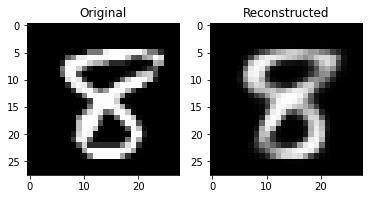

===> Epoch 12, Average loss: 106.001
Train Epoch 13 [Batch 0/235]	Loss: 106.500


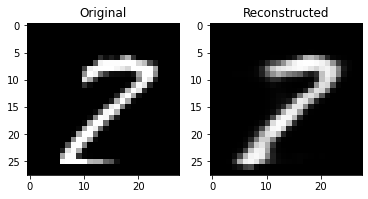

===> Epoch 13, Average loss: 105.696
Train Epoch 14 [Batch 0/235]	Loss: 106.394


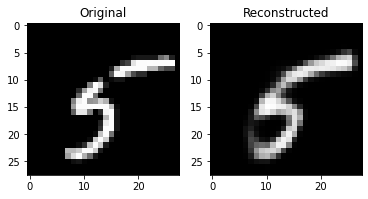

===> Epoch 14, Average loss: 105.436
Train Epoch 15 [Batch 0/235]	Loss: 105.475


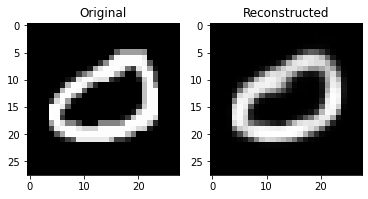

===> Epoch 15, Average loss: 105.125
Train Epoch 16 [Batch 0/235]	Loss: 104.733


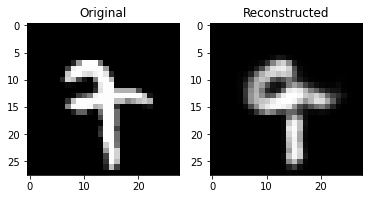

===> Epoch 16, Average loss: 104.902
Train Epoch 17 [Batch 0/235]	Loss: 103.783


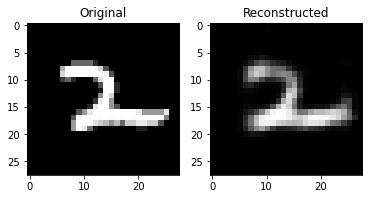

===> Epoch 17, Average loss: 104.648
Train Epoch 18 [Batch 0/235]	Loss: 105.389


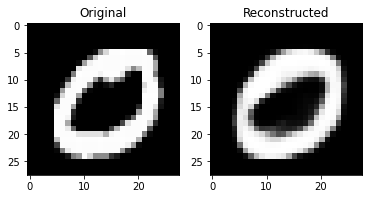

===> Epoch 18, Average loss: 104.499
Train Epoch 19 [Batch 0/235]	Loss: 103.404


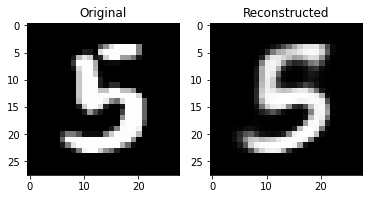

===> Epoch 19, Average loss: 104.328
Train Epoch 20 [Batch 0/235]	Loss: 105.169


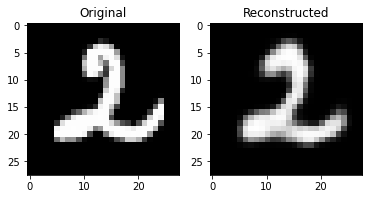

===> Epoch 20, Average loss: 104.129
Train Epoch 21 [Batch 0/235]	Loss: 104.123


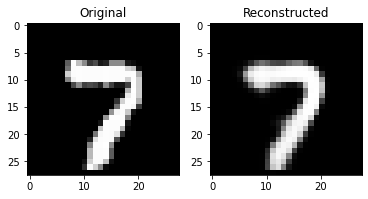

===> Epoch 21, Average loss: 103.938
Train Epoch 22 [Batch 0/235]	Loss: 104.871


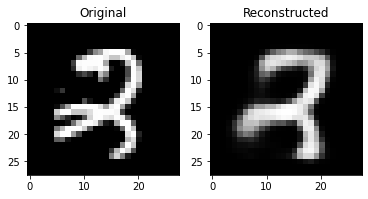

===> Epoch 22, Average loss: 103.850
Train Epoch 23 [Batch 0/235]	Loss: 104.262


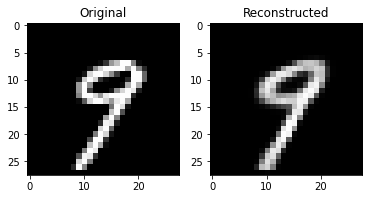

===> Epoch 23, Average loss: 103.669
Train Epoch 24 [Batch 0/235]	Loss: 103.438


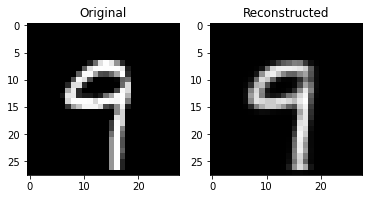

===> Epoch 24, Average loss: 103.561


In [5]:
for i in range(epochs):
    train(model=model, epoch=i)

Test image idx 0, latent var value: (tensor([[ 1.1139e-01,  1.2789e-01, -1.1953e-01,  7.2997e-02, -3.9709e-02,
          2.4157e-02, -1.3923e-01,  1.4714e-01,  1.9853e-02,  5.3120e-02,
         -4.9353e-02, -1.1750e-01,  9.4436e-03, -1.0830e-01,  4.2620e-01,
          2.4727e-04,  3.5254e-02,  3.7673e-02, -1.2645e-01, -7.5491e-03,
          4.7283e-02,  1.3529e+00,  3.8283e-02,  5.6383e-02, -2.0473e+00,
         -1.5365e-02, -1.4653e-02,  6.1219e-02, -7.7125e-03, -6.3219e-02,
         -4.9342e-01, -6.4689e-03,  1.0275e-01,  1.1461e+00, -2.0809e-02,
          8.8359e-02,  1.0355e-01,  6.3189e-03,  5.7887e-01, -5.0522e-02,
          1.0047e-01,  9.0709e-03,  2.3130e-02, -5.0106e-02, -9.7922e-02,
          1.1318e-01, -6.2065e-02,  5.7909e-02,  6.9474e-02,  7.6346e-02,
          1.0796e-02, -4.7782e-03, -5.3219e-01,  1.6844e+00, -1.2708e-02,
          4.3025e-01,  1.8895e-01,  5.8209e-02, -9.3201e-02,  7.3527e-02,
          2.6172e-02,  3.6967e-02,  5.2962e-02,  5.2673e-02, -3.3742e-02,
 

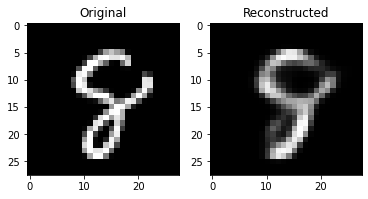

Test image idx 3000, latent var value: (tensor([[ 8.2071e-03, -5.7312e-02, -1.4309e+00,  1.6017e-01, -5.2686e-01,
          1.9454e-02,  1.0329e-01, -7.9843e-02, -5.2466e-02, -1.6518e-01,
          1.2233e-01, -4.6375e-01, -4.8004e-02,  8.7656e-02,  1.3412e-01,
         -8.2171e-02,  1.4165e-02, -6.3999e-02,  4.8678e-03,  1.3329e-01,
          9.8086e-02, -1.7105e+00, -1.1226e-01, -9.4869e-03,  1.9144e+00,
         -9.3732e-02,  2.2534e-02,  8.7086e-02,  7.4183e-02, -2.5964e-02,
          1.4512e+00, -6.4412e-02, -5.8431e-02,  3.5126e-01,  5.2758e-02,
         -5.9545e-02, -1.2666e-01, -6.1397e-02, -6.6725e-02, -1.5413e-01,
         -1.7608e-01,  5.9999e-02, -2.9653e-02,  7.5655e-02, -2.9009e-03,
         -2.0757e-01, -4.0194e-02,  1.2864e-01, -3.8581e-02,  1.2550e-02,
         -9.2203e-02,  7.4075e-02, -4.0418e-01,  5.4229e-02, -2.3597e-02,
         -1.2912e+00, -2.2722e-01,  2.8177e-02,  1.0836e-01, -1.1122e-01,
         -2.1004e-01,  2.4785e-02,  9.8030e-02, -1.5978e-01,  5.6457e-02

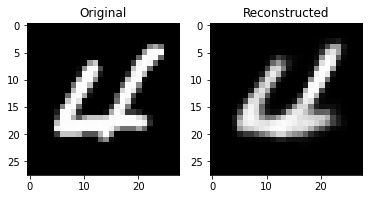

Test image idx 6000, latent var value: (tensor([[-2.2743e-02, -6.9410e-02, -7.5801e-01,  9.2030e-02, -9.1079e-01,
         -6.6208e-02,  2.8802e-02, -5.2952e-03,  1.1019e-02,  1.1818e-02,
          5.4464e-02, -7.9241e-02, -3.7292e-02,  2.6116e-02, -1.4611e-01,
          1.9251e-02, -5.8408e-02, -8.1277e-02,  1.0206e-02,  1.7208e-02,
         -7.9087e-03, -6.0827e-01, -4.6657e-02,  2.5150e-02,  5.0950e-01,
         -2.8454e-02,  2.9690e-03,  5.1784e-02,  4.7353e-02,  1.8426e-03,
         -1.0933e-01, -2.4453e-02, -2.5924e-02,  2.1401e-01, -2.5409e-03,
         -2.5770e-02, -2.3100e-02, -5.0090e-03,  6.0175e-01, -6.8060e-03,
         -8.6001e-02,  8.7614e-04,  6.5877e-02, -1.1157e-02, -3.7904e-02,
         -8.7377e-02, -1.4342e-02,  1.2046e-02, -5.8603e-03, -1.5783e-02,
         -7.1600e-02,  1.2234e-02, -1.0179e+00,  1.0210e+00, -8.0228e-04,
         -5.1701e-03, -3.4740e-04,  4.9592e-02,  2.1457e-02, -2.2750e-02,
         -6.9030e-02,  3.5991e-02, -4.5938e-02, -1.1654e-01,  3.9935e-02

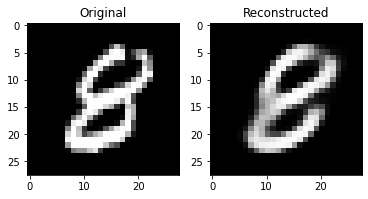

Test image idx 9000, latent var value: (tensor([[ 4.0820e-02,  1.6414e-02,  1.0339e-01,  5.9049e-02, -2.4118e-01,
          9.7207e-03, -2.4616e-03,  4.6757e-02,  2.9594e-02,  4.4981e-02,
          1.2945e-02, -5.8601e-02,  2.4833e-02,  4.7493e-03,  5.0848e-03,
          1.8594e-02, -2.0844e-02, -2.4617e-02,  3.7200e-02,  8.2634e-03,
          6.5344e-04,  1.3764e+00,  1.9833e-02,  2.8696e-02, -5.7413e-01,
          5.6638e-02, -3.5580e-02,  5.0079e-02,  4.5735e-02, -1.5595e-02,
         -1.1038e+00,  3.3567e-02, -7.7030e-02, -3.5081e-01,  5.2899e-02,
         -2.7263e-02, -1.8355e-02, -2.9657e-02,  2.3821e-02, -1.5068e-02,
         -9.6816e-02, -2.2865e-02, -7.2179e-03, -1.2682e-02,  4.7097e-03,
          6.3982e-02, -2.4918e-02,  1.6158e-02, -1.9993e-02, -8.6073e-03,
         -2.2494e-02, -4.3552e-02,  2.7937e+00,  5.2695e-01,  4.2103e-03,
          6.2111e-01,  4.6175e-02,  3.6117e-03, -1.9168e-02,  3.7063e-02,
         -4.6892e-02,  3.8104e-02,  3.6523e-02,  6.7743e-02,  2.6306e-02

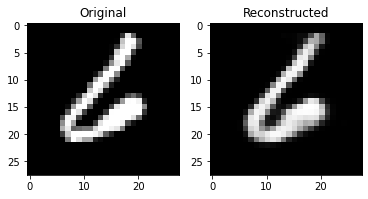

===> Test, Average loss: 103.623


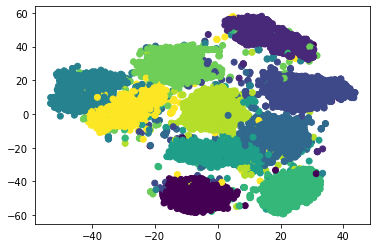

In [6]:
latent, labels = val(model)
plot_latenet(latent, labels, algo='tsne')

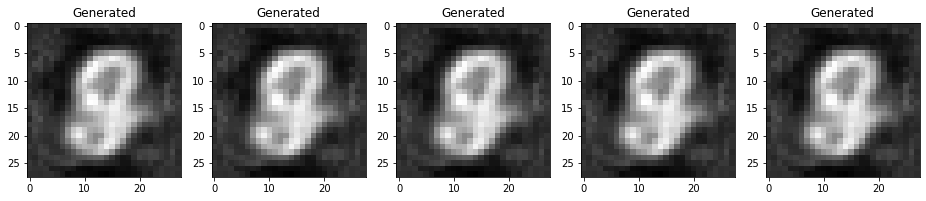

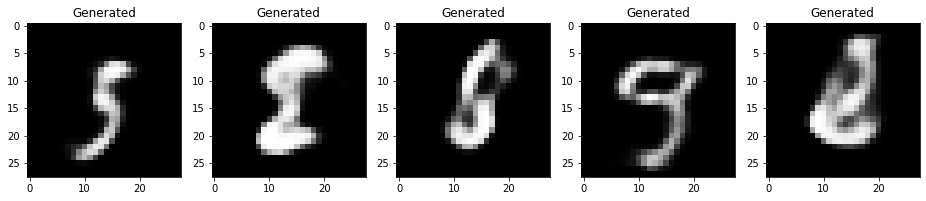

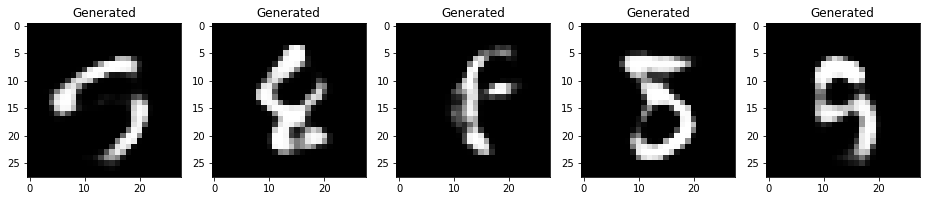

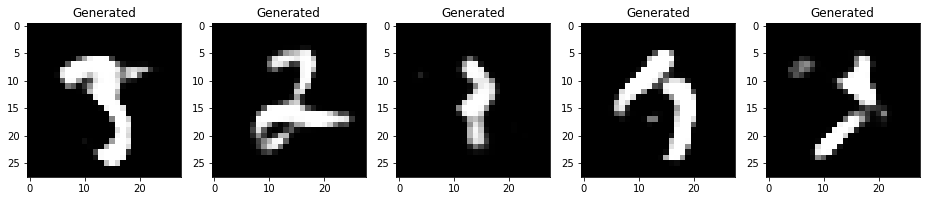

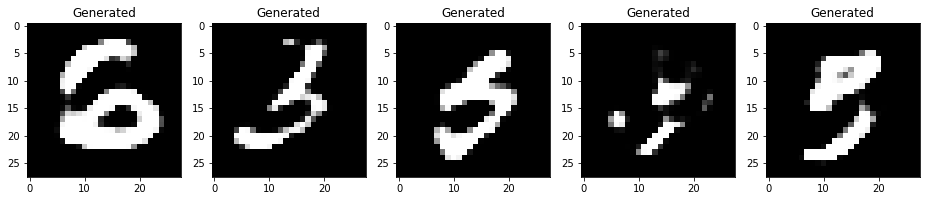

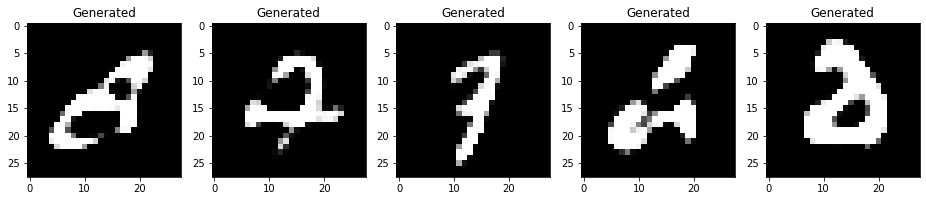

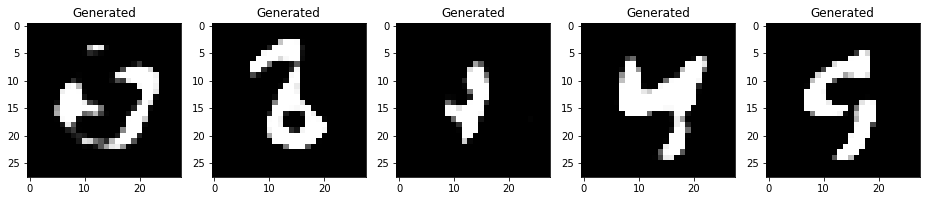

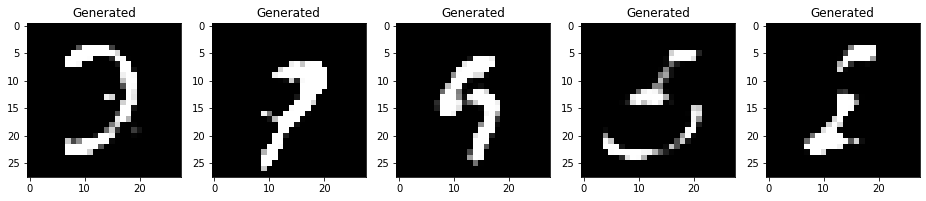

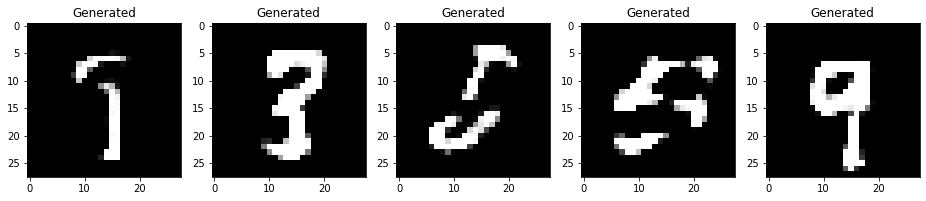

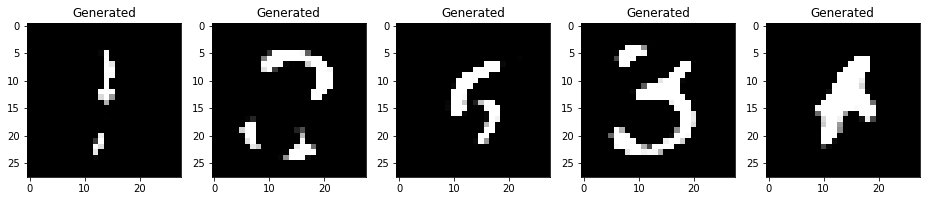

In [12]:
for i in range(10):
    images = []
    for j in range(5):
        z = torch.randn(1,latent_dim) * i
        image = model.decode(z=z).view(28,28).detach().numpy() 
        images.append(image)
    plot_images(images=images) 